# Raw Data Maker

This notebook creates a training dataset to feed into the AP-SVM model. First, we load modules and files.

In [ ]:
# Load modules 
import os, json, lgdo
import numpy as np
import matplotlib.pyplot as plt
import legendstyles
    
# Set plot style 
plt.style.use(legendstyles.LEGEND)

We construct the training dataset differently depending on the analysis software stack and the data type. For [pygama](https://github.com/legend-exp/pygama), we need to train one model that contains both **phy** and **cal** data so that it can be incorporated into the dataflow. For [juleana](https://github.com/legend-exp/Juleana.jl), we can train separate models for **phy** and **cal** data.

In [1]:
data_type = "cal"
stack = "juleana"

l200_data_dir = "/global/cfs/projectdirs/m2676/data/lngs/l200"
prod_env_dir = l200_data_dir + "/public/prodenv-new/prod-blind"
period = "p10"
run = 

if stack == "juleana":
    
    raw_dir = prod_env_dir + f"/ref-raw/generated/tier/raw/{data_type}/{period}/{run}"
    raw_files = sorted([os.path.abspath(os.path.join(raw_dir, p)) for p in os.listdir(raw_dir)])
    
elif stack == "pygama":
    
    raw_dir_phy = prod_env_dir + "/ref-raw/generated/tier/raw/phy" + run
    raw_dir_cal = prod_env_dir + "/ref-raw/generated/tier/raw/cal" + run

    raw_files_phy = sorted([os.path.abspath(os.path.join(raw_dir_phy, p)) for p in os.listdir(raw_dir_phy)])
    raw_files_cal = sorted([os.path.abspath(os.path.join(raw_dir_cal, p)) for p in os.listdir(raw_dir_cal)])

<KeysViewHDF5 ['abs_delta_mu_usec', 'baseline', 'board_id', 'channel', 'crate', 'daqenergy', 'deadtime', 'delta_mu_usec', 'dr_maxticks', 'dr_start_pps', 'dr_start_ticks', 'dr_stop_pps', 'dr_stop_ticks', 'event_type', 'eventnumber', 'fc_input', 'fcid', 'mu_offset_sec', 'mu_offset_usec', 'numtraces', 'packet_id', 'presum_rate', 'runtime', 'slot', 't_sat_hi', 't_sat_lo', 'timestamp', 'to_master_sec', 'to_start_sec', 'to_start_usec', 'tracelist', 'ts_maxticks', 'ts_pps', 'ts_ticks', 'waveform_presummed', 'waveform_windowed']>

Print first raw file path to get timestamp.

In [2]:
if stack == "juleana":
    print(raw_files[0])
if stack == "pygama":
    print(raw_files_cal[0])

'/global/cfs/projectdirs/m2676/data/lngs/l200/public/prodenv-new/prod-blind/ref-raw/generated/tier/raw/phy/p10/r000/l200-p10-r000-phy-20240226T164758Z-tier_raw.lh5'

Next we construct a list of **processable** Germanium detectors corresponding to the period and run we want to analyze. For this, we use `pylegendmeta` to access LEGEND's metadata. It is highly recommended to clone the [legend-metadata] Github repo locally and specify its path. The metadata repo should be updated before running this cell. 

In [3]:
from legendmeta import LegendMetadata


lmeta = LegendMetadata(path='<path-to-legend-metadata>')
chmap = lmeta.channelmap(on='20240226T164758Z')  # get the channel map, copy timestamp from previous output

channels = chmap.map("system", unique=False)["geds"]  # select HPGe channels
channels = channels.map("analysis.processable", unique=False)[True]  # select processable channels

rawid_list = channels.map("daq.rawid").keys()
ch_list = ["ch" + str(rawid) for rawid in rawid_list]
print(ch_list)

['ch1104000', 'ch1104001', 'ch1104002', 'ch1104003', 'ch1104004', 'ch1104005', 'ch1105600', 'ch1105602', 'ch1105603', 'ch1107202', 'ch1107203', 'ch1107204', 'ch1107205', 'ch1108800', 'ch1108801', 'ch1108802', 'ch1108803', 'ch1110402', 'ch1110403', 'ch1110404', 'ch1112000', 'ch1112001', 'ch1112002', 'ch1112003', 'ch1112004', 'ch1112005', 'ch1113600', 'ch1113601', 'ch1113602', 'ch1113603', 'ch1113604', 'ch1113605', 'ch1115203', 'ch1115204', 'ch1116801', 'ch1116802', 'ch1116803', 'ch1116804', 'ch1116805', 'ch1118402', 'ch1118403', 'ch1118404', 'ch1118405', 'ch1120000', 'ch1120001', 'ch1120002', 'ch1120003', 'ch1120004', 'ch1120005', 'ch1121600', 'ch1121601', 'ch1121602', 'ch1121603', 'ch1121604', 'ch1121605', 'ch1078400', 'ch1078405', 'ch1080000', 'ch1080001', 'ch1080004', 'ch1080005', 'ch1081600', 'ch1081601', 'ch1081602', 'ch1081603', 'ch1081604', 'ch1081605', 'ch1083200', 'ch1083201', 'ch1083202', 'ch1083203', 'ch1083204', 'ch1083205', 'ch1084800', 'ch1084801', 'ch1084802', 'ch1084803'

Here we load a specified number of cycles. Each background cycle contains about 1,000 waveforms. We need 10,000 waveforms from all detectors in total, so reading in 20 **phy** files is more than enough. For **cal** data one file is enough. For **phy** data, we remove forced/baseline and pulser triggers.

In [4]:
from lgdo.lh5 import read_as

if stack == "juleana":
    if data_type == "phy":
        
        n_files = 20
        raw_files_in = raw_files[0:n_files]
        
        bltrigger = read_as('ch1027200/raw/daqenergy', raw_files_in, 'np')
        pulser = read_as('ch1027201/raw/daqenergy', raw_files_in, 'np')
        
        idxs_pass = np.where((pulser == 0) & (bltrigger == 0))[0]
        
    elif data_type == "cal":
        
        n_files = 1
        
if stack == "pygama":
    
    n_files_phy = 20
    n_files_cal = 1 

    raw_files_phy_in = raw_files_phy[0:n_files_phy]
    raw_files_cal_in = raw_files_cal[0:n_files_cal]

    bltrigger = read_as('ch1027200/raw/daqenergy', raw_files_phy_in, 'np')
    pulser = read_as('ch1027201/raw/daqenergy', raw_files_phy_in, 'np')
    
    idxs_pass = np.where((pulser == 0) & (bltrigger == 0))[0]

To construct the training dataset, we evenly select waveforms from all processable Germanium detectors. For each detector, we choose half of the waveforms with ```daqenergy == 0``` and the other half with ```daqenergy > 0``` for **phy** data. We do not pre-apply any cuts for **cal** data. 

In [6]:
import time, tqdm

if stack == "juleana" and data_type == "phy":
    
    n_max = round(5000/len(ch_list)+1)
    train_file = f'../data/l200-{period}-{run}-{data_type}-ml_train_raw.lh5'

    start_time = time.time()

    for ch in tqdm.tqdm(ch_list):

        tb_pass, _ = sto.read(ch + '/raw/daqenergy', 
                              raw_files_in, 
                              idx=idxs_pass)
        daqenergies = tb_pass.nda

        idxs_hi, idxs_lo = np.where(daqenergies > 0)[0][0:n_max], np.where(daqenergies == 0)[0][0:n_max]
        idxs = sorted(np.concatenate([idxs_hi, idxs_lo]))

        tb_raw, n_read = sto.read(ch + '/raw', raw_files_in, idx=idxs_pass[idxs])
        print(ch, n_read) # Useful to check if enough events are being read
        tb_raw['rawid'] = lgdo.Array(np.full(n_read, int(ch[2:])))

        # Write tables to training dataset file 
        sto.write(tb_raw,
                  name = 'raw',
                  lh5_file = train_file,
                  group = 'ml_train',
                  wo_mode = 'a') 

    print("--- %s minutes elapsed ---" % ((time.time() - start_time)/60))
    
elif stack == "juleana" and data_type == "cal":
    
    n_max = round(10000/len(ch_list)+1)
    train_file = f'../data/l200-{period}-{run}-{data_type}-ml_train_raw.lh5'

    start_time = time.time()

    for ch in tqdm.tqdm(ch_list):

        tb_raw, n_read = sto.read(ch + '/raw', raw_files_in, n_rows=n_max)
        print(ch, n_read) # Useful to check if enough events are being read
        tb_raw['rawid'] = lgdo.Array(np.full(n_read, int(ch[2:])))

        # Write tables to training dataset file 
        sto.write(tb_raw,
                  name = 'raw',
                  lh5_file = train_file,
                  group = 'ml_train',
                  wo_mode = 'a')

    print("--- %s minutes elapsed ---" % ((time.time() - start_time)/60))
    
elif stack == "pygama":
    
    n_max_phy = round(5000/len(ch_list))
    n_max_cal = round(10000/len(ch_list))

    train_file = '../data/l200-p10-r000-phy-ml_train_raw.lh5'

    start_time = time.time()

    for ch in tqdm.tqdm(ch_list):

        tb_pass, _ = sto.read(ch + '/raw/daqenergy', 
                              raw_files_phy_in, 
                              idx=idxs_pass_phy)
        daqenergies = tb_pass.nda

        idxs_hi, idxs_lo = np.where(daqenergies > 0)[0][0:n_max_phy], np.where(daqenergies == 0)[0][0:n_max_phy]
        idxs = sorted(np.concatenate([idxs_hi, idxs_lo]))

        tb_raw_phy, n_phy = sto.read(ch + '/raw', raw_files_phy_in, idx=idxs_pass_phy[idxs])
        print(ch, n_phy) # Useful to check if enough events are being read
        tb_raw_phy['rawid'] = lgdo.Array(np.full(n_phy, int(ch[2:])))

        tb_raw_cal, n_cal = sto.read(ch + '/raw', raw_files_cal_in, n_rows=n_max_cal)
        print(ch, n_cal) # Useful to check if enough events are being read
        tb_raw_cal['rawid'] = lgdo.Array(np.full(n_cal, int(ch[2:])))

        # Write tables to training dataset file 
        sto.write(tb_raw_phy,
                  name = 'raw',
                  lh5_file = train_file,
                  group = 'ml_train',
                  wo_mode = 'a')

        sto.write(tb_raw_cal,
                  name = 'raw',
                  lh5_file = train_file,
                  group = 'ml_train',
                  wo_mode = 'a')

    print("--- %s minutes elapsed ---" % ((time.time() - start_time)/60))
    

  1%|          | 1/90 [00:05<08:51,  5.97s/it]

ch1104000 114


  2%|▏         | 2/90 [00:09<06:20,  4.32s/it]

ch1104001 114


  3%|▎         | 3/90 [00:12<05:34,  3.84s/it]

ch1104002 114


  4%|▍         | 4/90 [00:15<04:55,  3.44s/it]

ch1104003 114


  6%|▌         | 5/90 [00:17<04:14,  3.00s/it]

ch1104004 114


  7%|▋         | 6/90 [00:21<04:46,  3.41s/it]

ch1104005 114


  8%|▊         | 7/90 [00:24<04:28,  3.23s/it]

ch1105600 114


  9%|▉         | 8/90 [00:28<04:33,  3.34s/it]

ch1105602 114


 10%|█         | 9/90 [00:30<04:10,  3.09s/it]

ch1105603 114


 11%|█         | 10/90 [00:35<04:41,  3.52s/it]

ch1107202 114


 12%|█▏        | 11/90 [00:37<04:05,  3.11s/it]

ch1107203 114


 13%|█▎        | 12/90 [00:39<03:38,  2.81s/it]

ch1107204 114


 14%|█▍        | 13/90 [00:41<03:11,  2.48s/it]

ch1107205 114


 16%|█▌        | 14/90 [00:44<03:24,  2.70s/it]

ch1108800 114


 17%|█▋        | 15/90 [00:46<03:16,  2.61s/it]

ch1108801 114


 18%|█▊        | 16/90 [00:48<03:01,  2.45s/it]

ch1108802 114


 19%|█▉        | 17/90 [00:51<02:54,  2.38s/it]

ch1108803 114


 20%|██        | 18/90 [00:55<03:33,  2.97s/it]

ch1110402 114


 21%|██        | 19/90 [00:58<03:32,  2.99s/it]

ch1110403 114


 22%|██▏       | 20/90 [01:01<03:32,  3.04s/it]

ch1110404 114


 23%|██▎       | 21/90 [01:04<03:20,  2.91s/it]

ch1112000 114


 24%|██▍       | 22/90 [01:06<03:02,  2.69s/it]

ch1112001 114


 26%|██▌       | 23/90 [01:08<02:46,  2.49s/it]

ch1112002 114


 27%|██▋       | 24/90 [01:12<03:22,  3.08s/it]

ch1112003 114


 28%|██▊       | 25/90 [01:16<03:32,  3.27s/it]

ch1112004 114


 29%|██▉       | 26/90 [01:18<03:09,  2.97s/it]

ch1112005 114


 30%|███       | 27/90 [01:26<04:28,  4.25s/it]

ch1113600 114


 31%|███       | 28/90 [01:30<04:19,  4.18s/it]

ch1113601 114


 32%|███▏      | 29/90 [01:32<03:41,  3.63s/it]

ch1113602 114


 33%|███▎      | 30/90 [01:35<03:23,  3.39s/it]

ch1113603 114


 34%|███▍      | 31/90 [01:37<02:55,  2.98s/it]

ch1113604 114


 36%|███▌      | 32/90 [01:40<03:03,  3.16s/it]

ch1113605 114


 37%|███▋      | 33/90 [01:46<03:36,  3.80s/it]

ch1115203 114


 38%|███▊      | 34/90 [01:48<03:16,  3.51s/it]

ch1115204 114


 39%|███▉      | 35/90 [01:52<03:06,  3.39s/it]

ch1116801 114


 40%|████      | 36/90 [01:55<02:58,  3.30s/it]

ch1116802 114


 41%|████      | 37/90 [01:57<02:38,  2.98s/it]

ch1116803 114


 42%|████▏     | 38/90 [02:00<02:36,  3.01s/it]

ch1116804 114


 43%|████▎     | 39/90 [02:03<02:39,  3.13s/it]

ch1116805 114


 44%|████▍     | 40/90 [02:07<02:40,  3.21s/it]

ch1118402 114


 46%|████▌     | 41/90 [02:09<02:28,  3.04s/it]

ch1118403 114


 47%|████▋     | 42/90 [02:13<02:28,  3.10s/it]

ch1118404 114


 48%|████▊     | 43/90 [02:16<02:25,  3.11s/it]

ch1118405 114


 49%|████▉     | 44/90 [02:19<02:28,  3.22s/it]

ch1120000 114


 50%|█████     | 45/90 [02:22<02:16,  3.04s/it]

ch1120001 114


 51%|█████     | 46/90 [02:24<02:07,  2.89s/it]

ch1120002 114


 52%|█████▏    | 47/90 [02:29<02:19,  3.24s/it]

ch1120003 114


 53%|█████▎    | 48/90 [02:31<02:05,  2.98s/it]

ch1120004 57


 54%|█████▍    | 49/90 [02:34<02:00,  2.95s/it]

ch1120005 114


 56%|█████▌    | 50/90 [02:37<01:56,  2.92s/it]

ch1121600 114


 57%|█████▋    | 51/90 [02:39<01:45,  2.70s/it]

ch1121601 114


 58%|█████▊    | 52/90 [02:42<01:48,  2.84s/it]

ch1121602 114


 59%|█████▉    | 53/90 [02:45<01:44,  2.84s/it]

ch1121603 114


 60%|██████    | 54/90 [02:47<01:33,  2.60s/it]

ch1121604 114


 61%|██████    | 55/90 [02:49<01:30,  2.59s/it]

ch1121605 114


 62%|██████▏   | 56/90 [02:56<02:11,  3.86s/it]

ch1078400 114


 63%|██████▎   | 57/90 [03:01<02:12,  4.01s/it]

ch1078405 114


 64%|██████▍   | 58/90 [03:04<02:05,  3.92s/it]

ch1080000 114


 66%|██████▌   | 59/90 [03:07<01:53,  3.66s/it]

ch1080001 114


 67%|██████▋   | 60/90 [03:11<01:50,  3.67s/it]

ch1080004 114


 68%|██████▊   | 61/90 [03:14<01:41,  3.50s/it]

ch1080005 114


 69%|██████▉   | 62/90 [03:17<01:28,  3.17s/it]

ch1081600 114


 70%|███████   | 63/90 [03:19<01:21,  3.02s/it]

ch1081601 114


 71%|███████   | 64/90 [03:22<01:14,  2.87s/it]

ch1081602 114


 72%|███████▏  | 65/90 [03:25<01:11,  2.86s/it]

ch1081603 114


 73%|███████▎  | 66/90 [03:28<01:13,  3.05s/it]

ch1081604 114


 74%|███████▍  | 67/90 [03:32<01:15,  3.26s/it]

ch1081605 114


 76%|███████▌  | 68/90 [03:35<01:11,  3.27s/it]

ch1083200 114


 77%|███████▋  | 69/90 [03:38<01:08,  3.25s/it]

ch1083201 114


 78%|███████▊  | 70/90 [03:41<01:04,  3.21s/it]

ch1083202 114


 79%|███████▉  | 71/90 [03:45<01:02,  3.27s/it]

ch1083203 114


 80%|████████  | 72/90 [03:50<01:06,  3.70s/it]

ch1083204 114


 81%|████████  | 73/90 [03:53<00:59,  3.47s/it]

ch1083205 114


 82%|████████▏ | 74/90 [03:55<00:52,  3.28s/it]

ch1084800 114


 83%|████████▎ | 75/90 [03:58<00:45,  3.00s/it]

ch1084801 114


 84%|████████▍ | 76/90 [04:00<00:40,  2.87s/it]

ch1084802 114


 86%|████████▌ | 77/90 [04:02<00:34,  2.66s/it]

ch1084803 114


 87%|████████▋ | 78/90 [04:05<00:33,  2.77s/it]

ch1084804 114


 88%|████████▊ | 79/90 [04:08<00:29,  2.72s/it]

ch1084805 114


 89%|████████▉ | 80/90 [04:13<00:33,  3.35s/it]

ch1086400 114


 90%|█████████ | 81/90 [04:16<00:28,  3.16s/it]

ch1086401 114


 91%|█████████ | 82/90 [04:20<00:28,  3.53s/it]

ch1086403 114


 92%|█████████▏| 83/90 [04:24<00:24,  3.53s/it]

ch1086404 114


 93%|█████████▎| 84/90 [04:26<00:19,  3.22s/it]

ch1086405 114


 94%|█████████▍| 85/90 [04:29<00:16,  3.24s/it]

ch1088001 114


 96%|█████████▌| 86/90 [04:33<00:13,  3.34s/it]

ch1088002 114


 97%|█████████▋| 87/90 [04:37<00:10,  3.51s/it]

ch1088003 114


 98%|█████████▊| 88/90 [04:41<00:07,  3.84s/it]

ch1089600 114


 99%|█████████▉| 89/90 [04:44<00:03,  3.55s/it]

ch1089601 114


100%|██████████| 90/90 [04:48<00:00,  3.21s/it]

ch1089603 114
--- 4.816712892055511 minutes elapsed ---


Sanity check to make sure the training dataset was correctly written.

In [7]:
from lgdo.lh5 import show
show(train_file)

/
└── ml_train · HDF5 group 
    └── raw · table{packet_id,eventnumber,timestamp,runtime,numtraces,tracelist,baseline,daqenergy,channel,ts_pps,ts_ticks,ts_maxticks,mu_offset_sec,mu_offset_usec,to_master_sec,delta_mu_usec,abs_delta_mu_usec,to_start_sec,to_start_usec,dr_start_pps,dr_start_ticks,dr_stop_pps,dr_stop_ticks,dr_maxticks,deadtime,event_type,fcid,crate,slot,board_id,fc_input,waveform_windowed,presum_rate,waveform_presummed,t_sat_lo,t_sat_hi,rawid} 
        ├── abs_delta_mu_usec · array<1>{real} 
        ├── baseline · array<1>{real} 
        ├── board_id · array<1>{real} 
        ├── channel · array<1>{real} 
        ├── crate · array<1>{real} 
        ├── daqenergy · array<1>{real} 
        ├── deadtime · array<1>{real} 
        ├── delta_mu_usec · array<1>{real} 
        ├── dr_maxticks · array<1>{real} 
        ├── dr_start_pps · array<1>{real} 
        ├── dr_start_ticks · array<1>{real} 
        ├── dr_stop_pps · array<1>{real} 
        ├── dr_stop_ticks · array<1>{real} 


Look at the energy spectrum of the training dataset. Make sure the number of waveforms is ~10,000 for **juleana** models, or ~20,000 for **pygama** models.

findfont: Font family 'roboto' not found.
findfont: Font family ['roboto'] not found. Falling back to DejaVu Sans.
findfont: Font family 'roboto' not found.


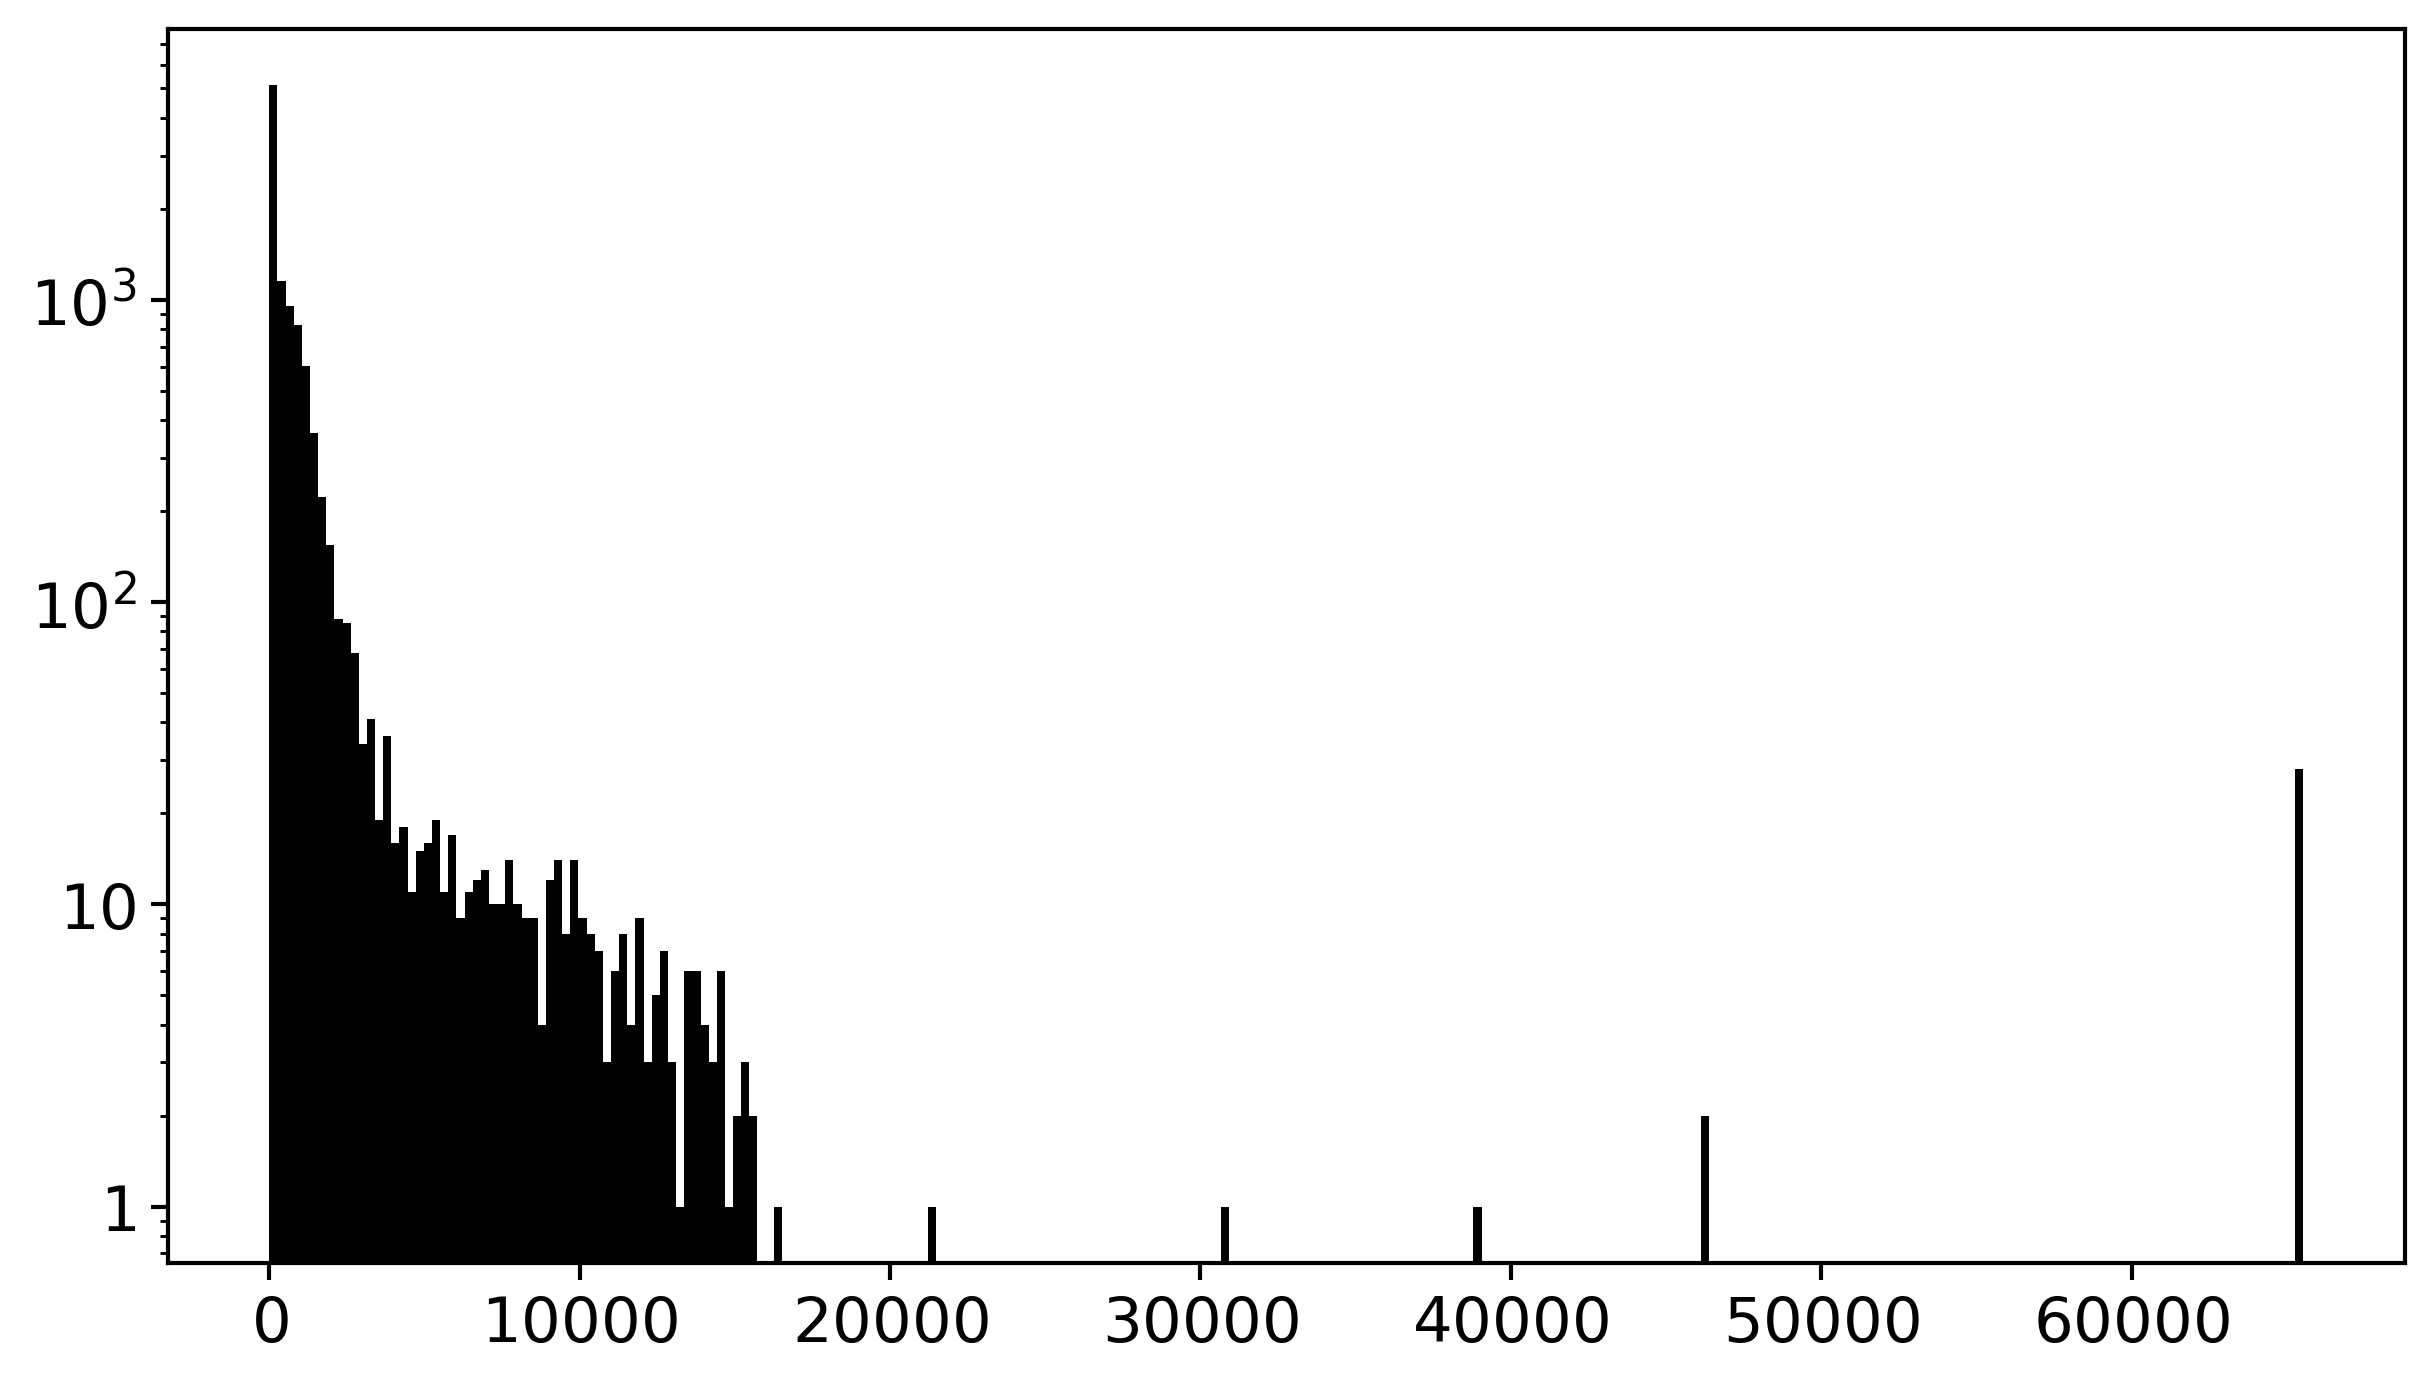

In [9]:
import matplotlib.pyplot as plt

tb, _ = sto.read('ml_train/raw', train_file)
daqenergies = tb['daqenergy'].nda
print(daqenergies.shape)

%matplotlib inline
plt.hist(daqenergies, bins=250)
plt.yscale('log')